Library

In [105]:
# -*- coding: utf-8 -*-
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles
from sklearn.metrics import confusion_matrix, accuracy_score

from scipy.stats import mode, chisquare


# use gp_minimize to do optimisation
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
#from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args


Create test dataset

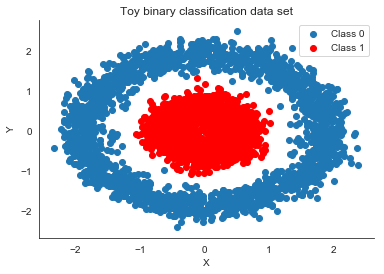

In [134]:
X, Y = make_circles(noise=0.1, factor=0.3, random_state=1, n_samples=4000, shuffle=True)
#X, Y = make_moons(noise=0.2, random_state=0, n_samples=4000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

#Model Creation functioin

In [143]:

# model creation function
def construct_nn(ann_input, ann_output, num_dense_nodes):
    n_hidden = num_dense_nodes

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.sigmoid(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.sigmoid(pm.math.dot(act_1,
                                         weights_1_2))
#        act_2 = pm.math.tanh(pm.math.dot(act_1,
#                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))
#        act_out = pm.math.sigmoid(pm.math.dot(act_1,
#                                              weights_2_out))
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network


# Setup hyperparameter search space

In [144]:
#### HYPER PREM TUNNING #####
# only change the number of nodes in each layer
dim_num_dense_nodes  = Integer(low=2, high=40, name='num_dense_nodes')
dimensions = [dim_num_dense_nodes]

In [155]:
# best accuracy will be updated with higher ones during the hyperparameter selection
best_accuracy  = 0.0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []


In [156]:
# creat fitness fucntion
# fitness function will evaluate the model performence for current parameter selection and return the -accuracy
@use_named_args(dimensions=dimensions)
def fitness(num_dense_nodes):
    # show current hyper paranmeter
    print('\nnum_dense_nodes:', num_dense_nodes)
    ann_input = theano.shared(X_train)
    ann_output = theano.shared(Y_train)
   # Create the neural network with these hyper-parameters.
    nn_model = construct_nn(ann_input, ann_output, num_dense_nodes=num_dense_nodes)



    with nn_model:
        #inference = pm.ADVI()
        #approx = pm.fit(n=3000, method=inference)
        step = pm.Metropolis()
        trace = pm.sample(1000, step=step)


    ann_input.set_value(X_test)
    ann_output.set_value(Y_test)

    # Creater posterior predictive samples
    ppc = pm.sample_ppc(trace, model=nn_model, samples=1000)
    pred = ppc['out'].mean(axis=0) > 0.5
    
    model_accurcy = (Y_test == pred).mean() * 100
    print('Accuracy = {}%'.format(model_accurcy))
    
    # output graph
    fig, ax = plt.subplots()
    ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
    ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
    sns.despine()
    ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');
    
    global parameter_hist
    global acc_hist
    # save parameter and accuracy history
    parameter_hist.append(num_dense_nodes)
    acc_hist.append(model_accurcy)
    
    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy
    global best_parameter
    
    global best_accuracy
    # If the classification accuracy of the saved model is improved ...
    if model_accurcy > best_accuracy:
        # Update the classification accuracy.
        best_accuracy = model_accurcy
        best_parameter = num_dense_nodes
        
    return -model_accurcy

In [157]:
# default parameter is 2 nodes per layer
default_parameters = [2]

# test a bayesian NN with hand pick paranmeter


num_dense_nodes: 3


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:10<00:00, 547.96draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.52it/s]


Accuracy = 65.60000000000001%


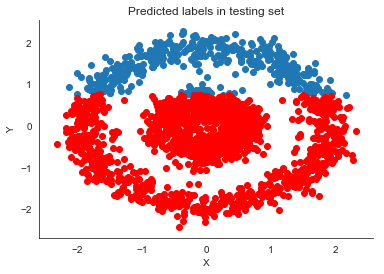

In [148]:
# test a bayesian NN with hand pick paranmeter
fitness(x=[3])


# reset all history and best accuracy
best_accuracy = 0.0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []

# We use Bayesian Optimization with gaussian process


num_dense_nodes: 2


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:09<00:00, 632.67draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 76.96it/s]


Accuracy = 66.25%

num_dense_nodes: 6


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:15<00:00, 399.03draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.52it/s]


Accuracy = 99.8%

num_dense_nodes: 34


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:55<00:00, 107.85draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.75it/s]


Accuracy = 99.85000000000001%

num_dense_nodes: 18


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:33<00:00, 179.39draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.31it/s]


Accuracy = 99.6%

num_dense_nodes: 35


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [00:58<00:00, 31.40draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.12it/s]


Accuracy = 99.95%

num_dense_nodes: 21


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:38<00:00, 156.81draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.19it/s]


Accuracy = 99.9%

num_dense_nodes: 30


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:50<00:00, 119.48draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.43it/s]


Accuracy = 99.8%

num_dense_nodes: 33


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:54<00:00, 110.02draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.29it/s]


Accuracy = 99.9%

num_dense_nodes: 21


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:36<00:00, 164.72draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.58it/s]


Accuracy = 99.75%

num_dense_nodes: 11


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:22<00:00, 265.19draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.98it/s]


Accuracy = 99.75%

num_dense_nodes: 28


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:47<00:00, 126.73draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.58it/s]


Accuracy = 99.8%

num_dense_nodes: 8


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:17<00:00, 343.44draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.74it/s]


Accuracy = 99.7%

num_dense_nodes: 40


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [01:02<00:00, 34.62draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.89it/s]


Accuracy = 99.8%

num_dense_nodes: 14


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:26<00:00, 225.41draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 52.86it/s]


Accuracy = 99.9%

num_dense_nodes: 24


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [00:40<00:00, 46.54draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.71it/s]


Accuracy = 99.8%

num_dense_nodes: 38


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [01:02<00:00, 95.81draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.28it/s]


Accuracy = 99.8%

num_dense_nodes: 7


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:17<00:00, 349.31draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.89it/s]


Accuracy = 99.85000000000001%

num_dense_nodes: 16


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:30<00:00, 199.68draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.16it/s]


Accuracy = 99.9%

num_dense_nodes: 26


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:43<00:00, 137.34draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 48.09it/s]


Accuracy = 99.9%

num_dense_nodes: 36


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:58<00:00, 103.19draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 48.10it/s]


Accuracy = 99.8%


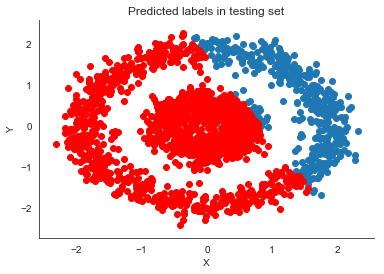

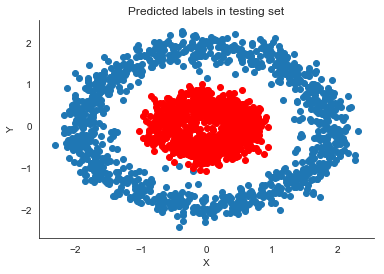

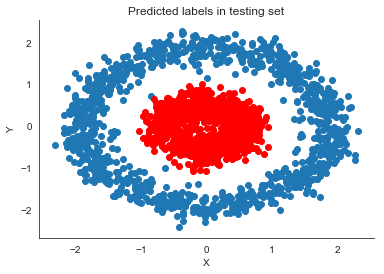

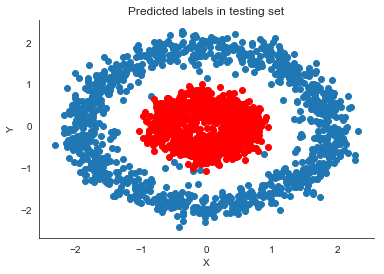

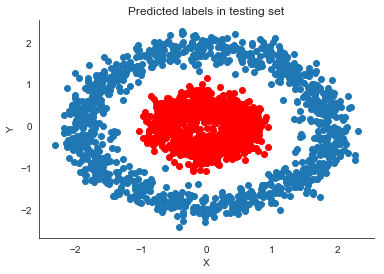

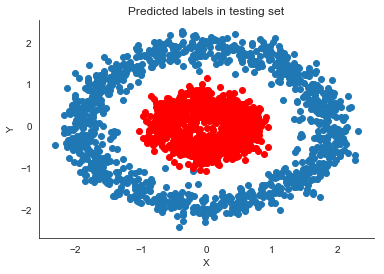

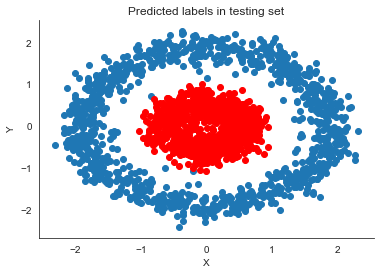

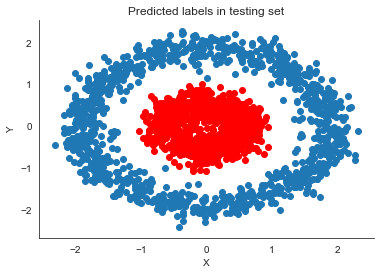

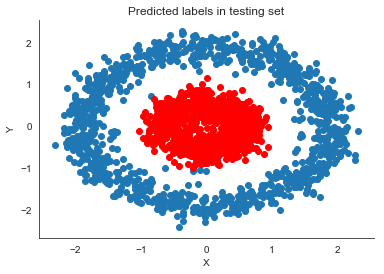

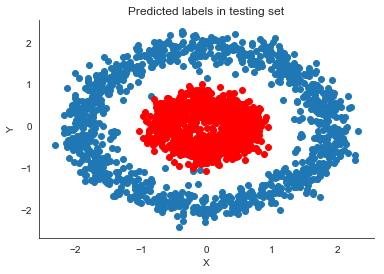

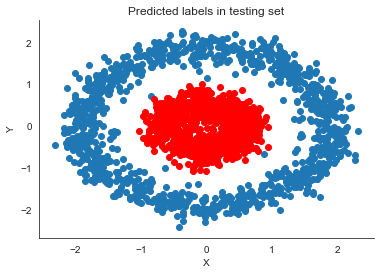

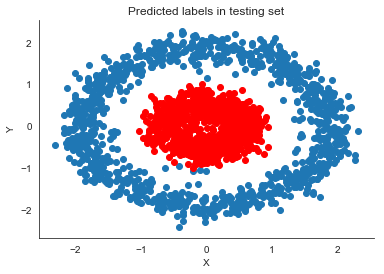

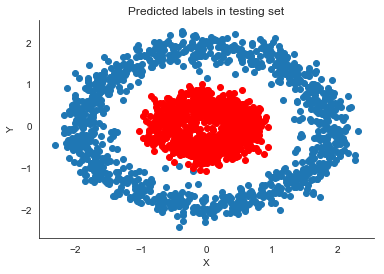

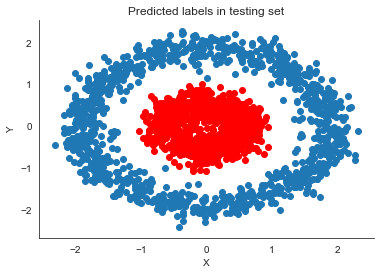

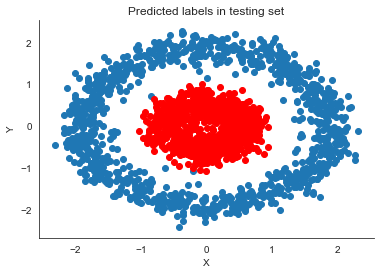

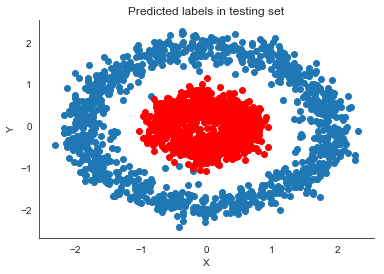

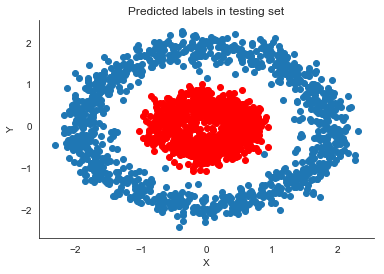

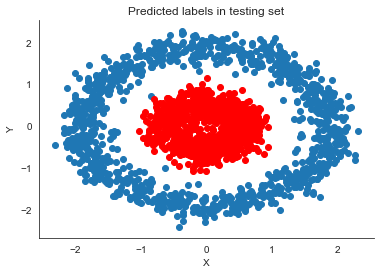

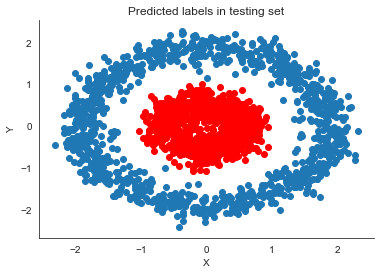

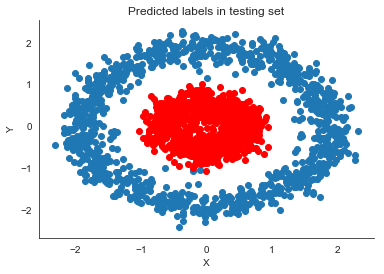

In [158]:
# start searching hyper parameter with gp
# we will do 11 call of fitness function, start with default parameters
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=20,
                            x0=default_parameters)

Text(0.5,1,'Result')

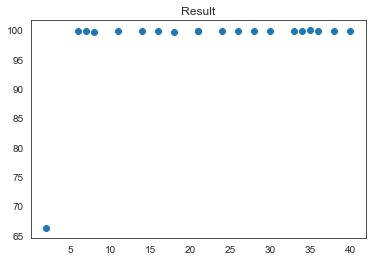

In [159]:

plt.scatter(parameter_hist, acc_hist)
plt.title('Result')


In [160]:
best_accuracy

99.95

In [161]:
best_parameter

35

In [162]:
parameter_hist

[2, 6, 34, 18, 35, 21, 30, 33, 21, 11, 28, 8, 40, 14, 24, 38, 7, 16, 26, 36]


num_dense_nodes: 35


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_2_out]
>Metropolis: [w_1_2]
>Metropolis: [w_in_1]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [00:59<00:00, 36.92draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.67it/s]


Accuracy = 99.85000000000001%


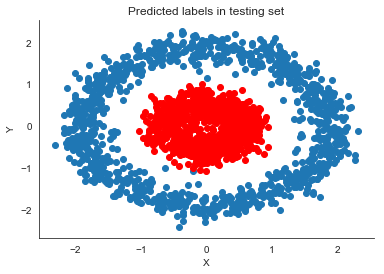

In [163]:
# test a bayesian NN with hand pick paranmeter
fitness(x=[35])


# reset all history and best accuracy
best_accuracy = 0.0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []

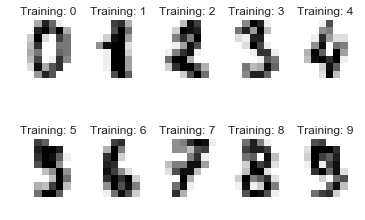

In [21]:
# MNIST dataset
digits = datasets.load_digits()
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [49]:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
Y = digits.target

X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

In [97]:

# model creation function
def construct_nn(ann_input, ann_output, num_dense_nodes):
    n_hidden = num_dense_nodes

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.sigmoid(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.sigmoid(pm.math.dot(act_1,
                                         weights_1_2))
#        act_2 = pm.math.tanh(pm.math.dot(act_1,
#                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))
#        act_out = pm.math.sigmoid(pm.math.dot(act_1,
#                                              weights_2_out))
        # Binary classification -> Bernoulli likelihood
        out = pm.Categorical('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network


In [98]:
#### HYPER PREM TUNNING #####
# only change the number of nodes in each layer
dim_num_dense_nodes  = Integer(low=2, high=40, name='num_dense_nodes')
dimensions = [dim_num_dense_nodes]

In [99]:
# best accuracy will be updated with higher ones during the hyperparameter selection
best_accuracy  = 0.0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []

#prediction list
Y_pred = []

In [100]:
# creat fitness fucntion
# fitness function will evaluate the model performence for current parameter selection and return the -accuracy
@use_named_args(dimensions=dimensions)
def fitness(num_dense_nodes):
    # show current hyper prem
    print('\nnum_dense_nodes:', num_dense_nodes)
    ann_input = theano.shared(X_train)
    ann_output = theano.shared(Y_train)
   # Create the neural network with these hyper-parameters.
    nn_model = construct_nn(ann_input, ann_output, num_dense_nodes=num_dense_nodes)



    with nn_model:
        #inference = pm.ADVI()
        #approx = pm.fit(n=3000, method=inference)
        step = pm.Metropolis()
        trace = pm.sample(2000, step=step)


    ann_input.set_value(X_test)
    ann_output.set_value(Y_test)

    # Creater posterior predictive samples
    ppc = pm.sample_ppc(trace, model=nn_model, samples=2000)
    pred = ppc['out'].mean(axis=0) > 0.5
    y_pred = mode(ppc['out'], axis=0).mode[0, :]
    
    Y_pred.append(y_pred)
    
    
    
    model_accurcy = (Y_test == pred).mean() * 100
    print('Accuracy = {}%'.format(model_accurcy))
    
    # save parameter and accuracy history
    parameter_hist.append(num_dense_nodes)
    acc_hist.append(model_accurcy)
    
    global best_accuracy
    # If the classification accuracy of the saved model is improved ...
    if model_accurcy > best_accuracy:
        # Update the classification accuracy.
        best_accuracy = model_accurcy

    return -model_accurcy

In [101]:
# default parameter is 2 nodes per layer
default_parameters = [2]

In [104]:
# test a bayesian NN with hand pick paranmeter
fitness(x=[11])


# reset all history and best accuracy
best_accuracy = 0.0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []


num_dense_nodes: 11


ValueError: shapes (898,11) and (10,) not aligned: 11 (dim 1) != 10 (dim 0)

In [103]:
sns.heatmap(confusion_matrix(Y_test, Y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [899, 0]

In [79]:
Y_test

array([9., 1., 1., 2., 6., 9., 0., 7., 4., 6., 4., 3., 5., 4., 6., 0., 4.,
       9., 9., 7., 4., 1., 6., 0., 1., 5., 7., 1., 9., 1., 1., 2., 3., 9.,
       0., 0., 3., 6., 3., 6., 4., 5., 5., 5., 7., 7., 7., 3., 0., 1., 1.,
       0., 2., 1., 3., 6., 6., 1., 9., 6., 1., 9., 0., 5., 4., 8., 2., 8.,
       4., 1., 8., 0., 6., 6., 6., 0., 5., 1., 2., 9., 7., 0., 6., 8., 5.,
       3., 8., 6., 6., 8., 2., 7., 1., 2., 9., 1., 9., 5., 1., 4., 1., 7.,
       2., 9., 1., 0., 6., 5., 3., 5., 1., 7., 8., 2., 3., 4., 4., 4., 4.,
       0., 8., 2., 3., 9., 1., 8., 0., 4., 7., 8., 0., 1., 4., 1., 0., 1.,
       2., 5., 4., 7., 9., 9., 7., 0., 4., 4., 9., 2., 4., 8., 4., 1., 6.,
       9., 7., 8., 5., 7., 7., 0., 3., 6., 5., 4., 3., 2., 5., 6., 0., 6.,
       7., 5., 8., 9., 8., 2., 1., 9., 3., 5., 1., 7., 7., 4., 0., 1., 4.,
       9., 0., 6., 7., 2., 9., 6., 4., 6., 6., 8., 9., 7., 3., 5., 6., 3.,
       5., 3., 0., 1., 3., 7., 6., 1., 3., 6., 0., 3., 2., 7., 2., 9., 5.,
       1., 3., 4., 5., 9.

In [90]:
Y_pred

[array([375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375,
        375, 375, 375, 375, 375, 375, 375, 375, 375